# Use `while` loop

## Introduction
With the while loop we can execute a set of tasks as long as the condition is true. In this tutorial, you will learn how to use `while` loop in WorkGraph.

There are two ways to implement a `while` loop in WorkGraph:

- Using `While` Task
- Using `While` WorkGraph

## Using `While` Task

The `While` task allows running tasks many times in a loop. One can add a `While` task to the WorkGraph and specify the conditions and tasks to run in the loop.

```python
wg.add_task("While",
              max_iterations=100,
              conditions=["should_run"],
              tasks=["add2", "multiply1", "compare1"])
```

Parameters:

- **max_iterations**
- **conditions**: a list of variables from the `context`. When any of them is `False`, the while loop exit.
- **tasks**: a list of names of the the tasks inside the while loop.


### Example

Suppose we want to calculate the following workflow, the tasks for each step are shown:


In [26]:
from aiida.engine import  calcfunction
from aiida import load_profile

load_profile()

@calcfunction
def compare(x, y):
    return x < y

@calcfunction
def add(x, y):
    return x + y

@calcfunction
def multiply(x, y):
    return x*y

#-------------------------------------------------------------------
# start while block
n = add(1, 1)            # task add1
# start while loop
while compare(n, 50):    # task compare
    n = add(n, 1)        # task add2
    n = multiply(n, 2)   # task multiply1
# end while block
z = add(n, 1)            # task add3
#-------------------------------------------------------------------

print("Result: ", z)

Result:  uuid: 516fe11f-8060-4773-925e-b3f5ba22f290 (pk: 97696) value: 63


### Create the workflow
Now, let'use create the workflow using the `While` task.

In [27]:
from aiida_workgraph import task, WorkGraph

wg = WorkGraph("test_while_task")
# set a context variable before running.
wg.context = {"should_run": True}
add1 = wg.add_task(add, name="add1", x=1, y=1)
add1.set_context({"result": "n"})
#---------------------------------------------------------------------
# Create the tasks in the while loop.
add2 = wg.add_task(add, name="add2", x="{{n}}", y=1)
add2.wait.append("add1")
multiply1 = wg.add_task(multiply, name="multiply1",
                        x=add2.outputs["result"],
                        y=2)
# update the context variable
multiply1.set_context({"result": "n"})
compare1 = wg.add_task(compare, name="compare1", x=multiply1.outputs["result"], y=50)
# Save the `result` of compare1 task as context.should_run, and used as condition
compare1.set_context({"result": "should_run"})
# Create the while tasks
while1 = wg.add_task("While", max_iterations=100,
                        conditions=["should_run"],
                        tasks=["add2", "multiply1", "compare1"])
#---------------------------------------------------------------------
add3 = wg.add_task(add, name="add3", x=1, y=1)
wg.add_link(multiply1.outputs["result"], add3.inputs["x"])
wg.to_html()
# comment out the following line to visualize the graph in the notebook
# wg

In the GUI, **While** task is shown as a **While Zone** with all its child tasks inside the Zone. 
The while zone does not have data input and output sockets. Tasks outside the while zone can link to the tasks inside the zone directly.

### Submit the WorkGraph and check the results


In [7]:
wg.submit(wait=True)
print("State of WorkGraph:   {}".format(wg.state))
print('Result of add1   :   {}'.format(add3.outputs["result"].value))

WorkGraph process created, PK: 97508
State of WorkGraph:   FINISHED
Result of add1   :   uuid: db4ff8aa-39bc-4f94-ba1b-04fabf9a93a5 (pk: 97551) value: 63


Generate node graph from the AiiDA process,and we can see that when `compare1` node outputs `False`, the workgraph stops.

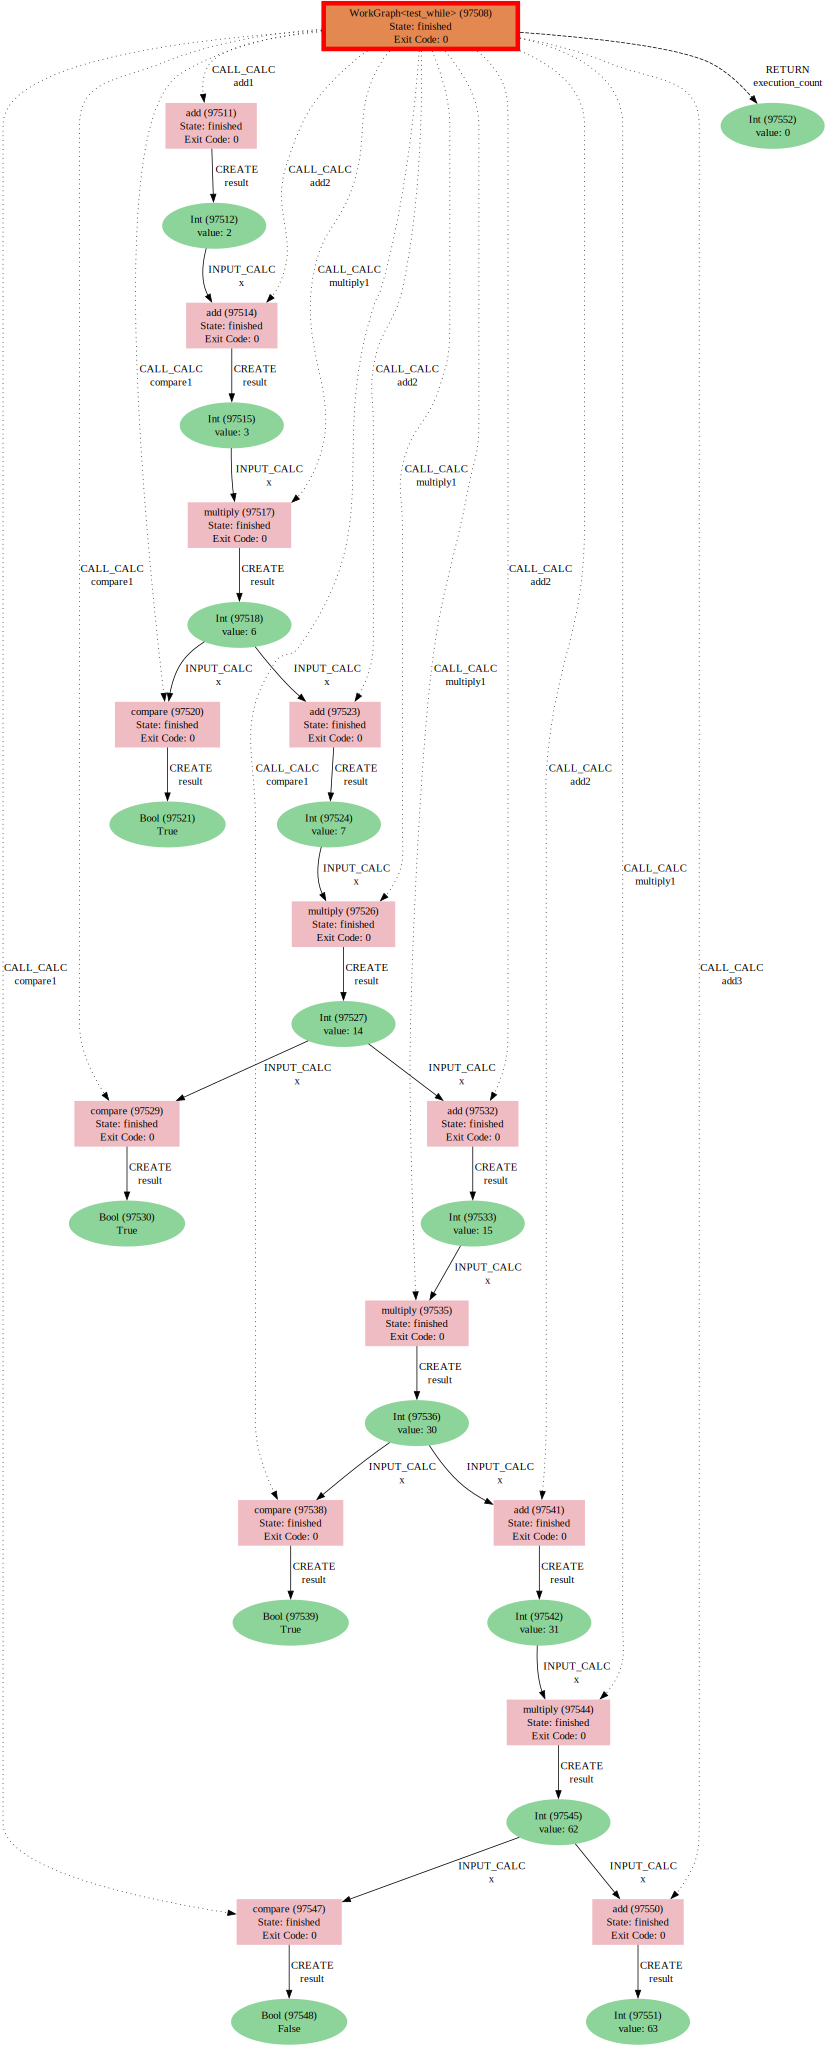

In [8]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## `While` WorkGraph
Create a WorkGraph will repeat itself based on the conditions.

In [29]:
# Output the result of from the context (context)
@task.graph_builder(outputs = [{"name": "result", "from": "context.n"}])
def add_multiply_while(n, limit=50):
    wg = WorkGraph()
    # tell the engine that this is a `while` workgraph
    wg.workgraph_type = "WHILE"
    # the `result` of compare1 taskis used as condition
    wg.conditions = ["compare1.result"]
    # set a context variable before running.
    wg.context = {"n": n}
    wg.add_task(compare, name="compare1", x="{{n}}", y=limit)
    add1 = wg.add_task(add, name="add1", x="{{ n }}", y=1)
    multiply1 = wg.add_task(multiply, name="multiply1", x=add1.outputs["result"],
                            y=2)
    # update the context variable
    multiply1.set_context({"result": "n"})
    return wg

### Create the workflow
Now, let'use the `add_multiply_while` task in the workflow.

In [30]:
wg = WorkGraph("test_while_workgraph")
add1 = wg.add_task(add, name="add1", x=1, y=1)
while1 = wg.add_task(add_multiply_while, n=add1.outputs["result"],
                     limit=50)
add2 = wg.add_task(add, name="add2", y=1)
wg.add_link(while1.outputs["result"], add2.inputs["x"])
wg.to_html()
# wg

### Submit the WorkGraph and check the results

In [31]:
wg.submit(wait=True)
print("State of WorkGraph:   {}".format(wg.state))
print('Result of add2  :   {}'.format(wg.tasks["add2"].outputs["result"].value))

WorkGraph process created, PK: 97697
State of WorkGraph:   FINISHED
Result of add2  :   uuid: eeec1b01-aa2c-423f-8295-3d3f0d3e4245 (pk: 97747) value: 63


Generate node graph from the AiiDA process,and we can see that when `compare1` node outputs `False`, the workgraph stops.

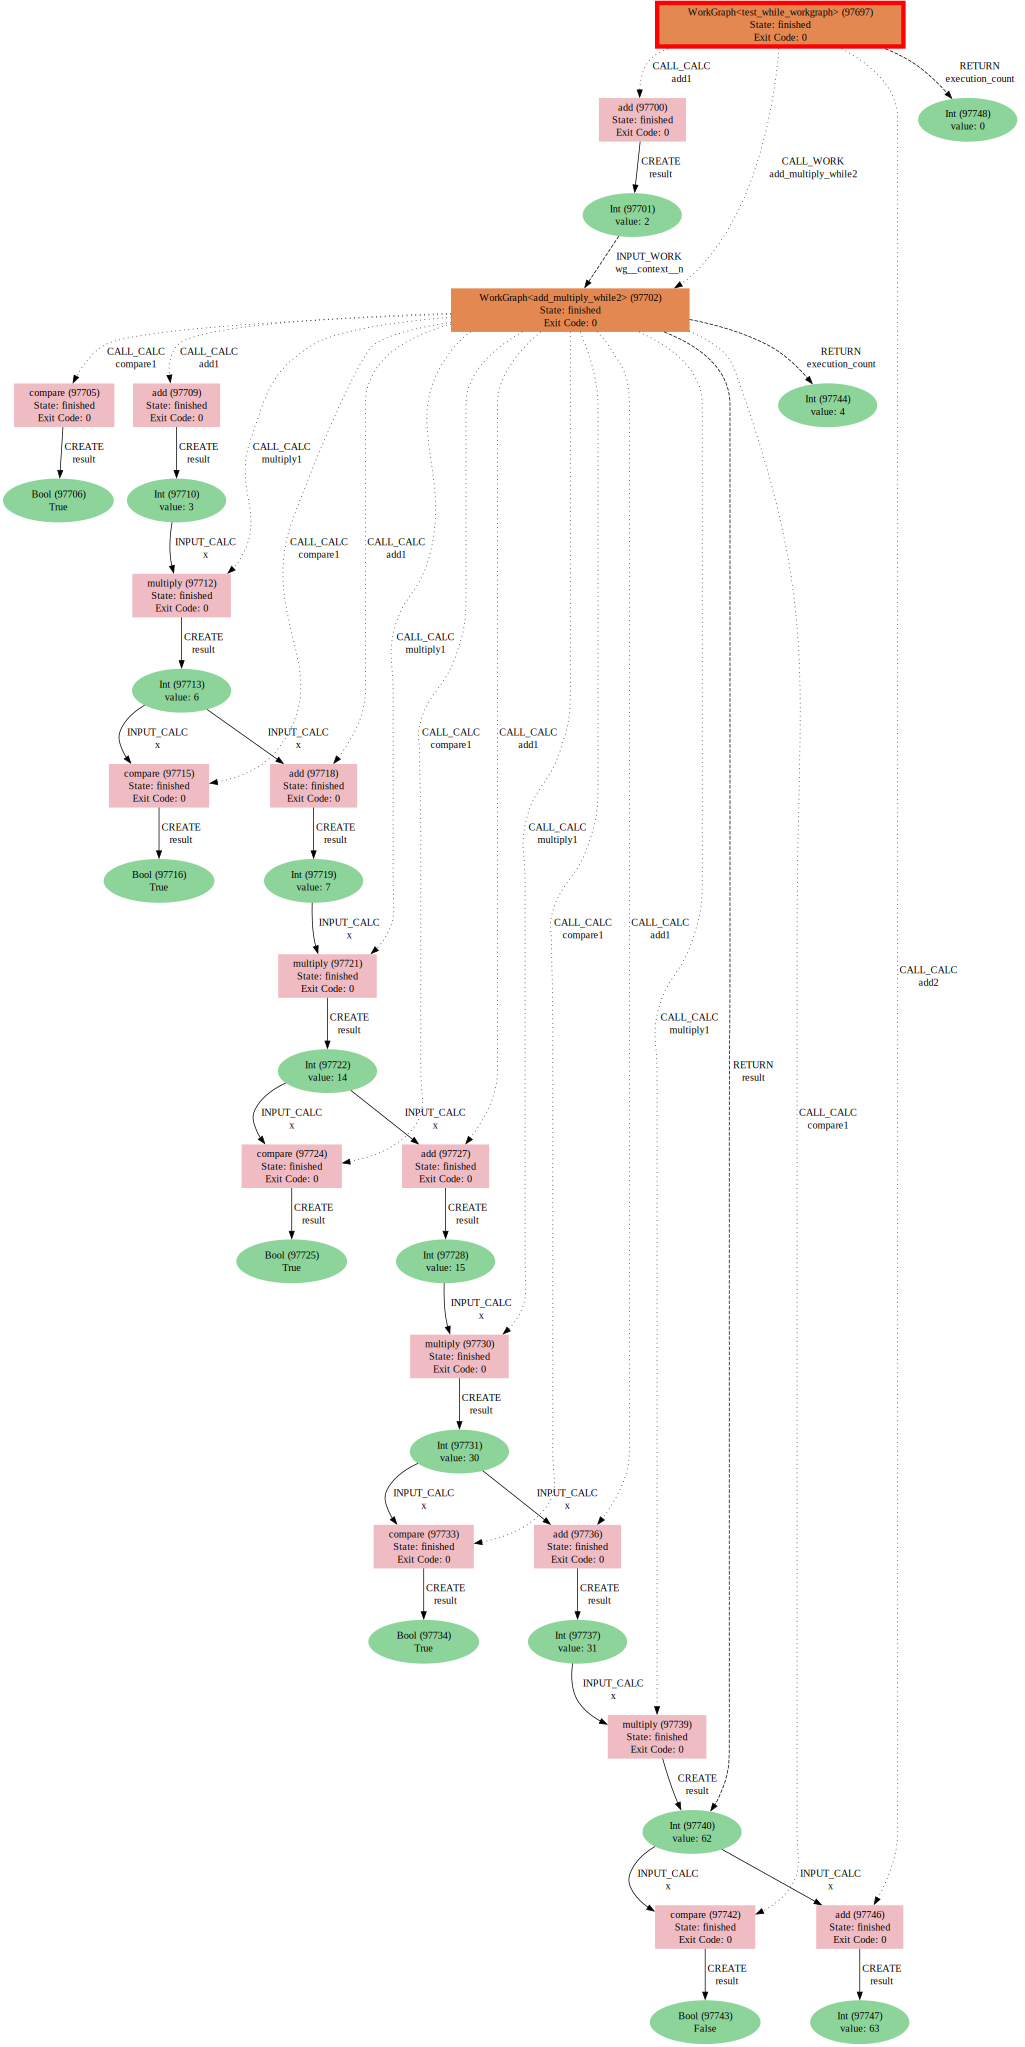

In [32]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

### Max iteration
One can set the maximum number of execution times (`max_iteration`) for the `While` WorkGraph.

In [ ]:
wg = WorkGraph()
wg.workgraph_type = "WHILE"
wg.max_iterations = 10